In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
import itertools

import sklearn
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox 

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg


from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [2]:
from google.colab import files
uploaded=files.upload()

Saving CO2 dataset.xlsx to CO2 dataset.xlsx


In [3]:
df=pd.read_excel(r"CO2 dataset.xlsx",header=0,index_col=0,parse_dates=True)
df

,CO2
Year,
1800.0,0.00568
1801.0,0.00561
1802.0,0.00555
1803.0,0.00548
1804.0,0.00542
...,...
2010.0,15.60000
2011.0,15.60000
2012.0,14.80000


# EDA

In [4]:
df.shape

(215, 1)

In [5]:
df.isnull().sum()

CO2    0
dtype: int64

In [6]:
df.describe()

,CO2
count,215.000000
mean,6.741970
std,6.522437
min,0.001750
25%,0.041050
50%,6.390000
75%,11.500000
max,18.200000


<AxesSubplot:xlabel='Year'>

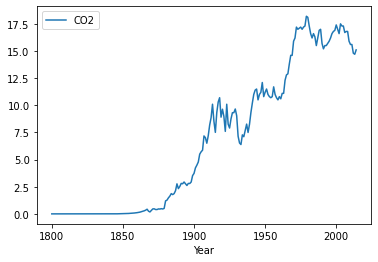

In [7]:
df.plot()

<AxesSubplot:>

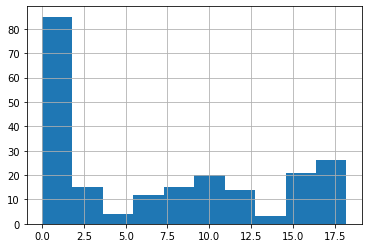

In [8]:
df['CO2'].hist()

<AxesSubplot:xlabel='CO2', ylabel='Density'>

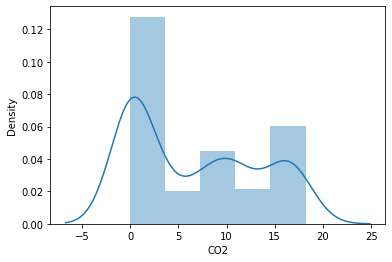

In [9]:
sns.distplot(df['CO2'])


#### Data distribution is not normal. So we apply some transformations and visualize the data.

### Box-Cox Transformation

In [10]:
df['co2_boxcox'] ,_=stats.boxcox(df['CO2'])
df

,CO2,co2_boxcox
Year,,
1800.0,0.00568,-3.094412
1801.0,0.00561,-3.098401
1802.0,0.00555,-3.101852
1803.0,0.00548,-3.105915
1804.0,0.00542,-3.109430
...,...,...
2010.0,15.60000,3.767993
2011.0,15.60000,3.767993
2012.0,14.80000,3.672451


(array([49.,  9.,  8., 14.,  2.,  8., 13., 16., 44., 52.]),
 array([-3.42876031, -2.68046638, -1.93217246, -1.18387854, -0.43558462,
         0.3127093 ,  1.06100323,  1.80929715,  2.55759107,  3.30588499,
         4.05417892]),
 <BarContainer object of 10 artists>)

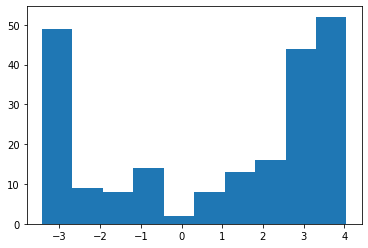

In [11]:
plt.hist(df['co2_boxcox'])

### Log Transform

In [12]:
df['log_co2']=pd.Series(np.log(df['CO2']))
df

,CO2,co2_boxcox,log_co2
Year,,,
1800.0,0.00568,-3.094412,-5.170804
1801.0,0.00561,-3.098401,-5.183205
1802.0,0.00555,-3.101852,-5.193957
1803.0,0.00548,-3.105915,-5.206650
1804.0,0.00542,-3.109430,-5.217659
...,...,...,...
2010.0,15.60000,3.767993,2.747271
2011.0,15.60000,3.767993,2.747271
2012.0,14.80000,3.672451,2.694627


(array([ 28.,  18.,   6.,   5.,   6.,  11.,   6.,  17.,  18., 100.]),
 array([-6.34813949, -5.42318338, -4.49822727, -3.57327117, -2.64831506,
        -1.72335895, -0.79840284,  0.12655327,  1.05150938,  1.97646549,
         2.90142159]),
 <BarContainer object of 10 artists>)

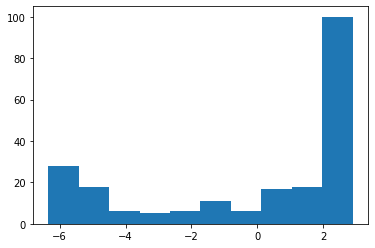

In [13]:
plt.hist(df['log_co2'])

### Square-root transform

In [14]:
df['square_co2']=np.sqrt(df['CO2'])
df

,CO2,co2_boxcox,log_co2,square_co2
Year,,,,
1800.0,0.00568,-3.094412,-5.170804,0.075366
1801.0,0.00561,-3.098401,-5.183205,0.074900
1802.0,0.00555,-3.101852,-5.193957,0.074498
1803.0,0.00548,-3.105915,-5.206650,0.074027
1804.0,0.00542,-3.109430,-5.217659,0.073621
...,...,...,...,...
2010.0,15.60000,3.767993,2.747271,3.949684
2011.0,15.60000,3.767993,2.747271,3.949684
2012.0,14.80000,3.672451,2.694627,3.847077


(array([65., 15.,  4., 15.,  4.,  7., 20., 33.,  8., 44.]),
 array([0.041833  , 0.46426428, 0.88669556, 1.30912684, 1.73155812,
        2.1539894 , 2.57642068, 2.99885196, 3.42128324, 3.84371452,
        4.2661458 ]),
 <BarContainer object of 10 artists>)

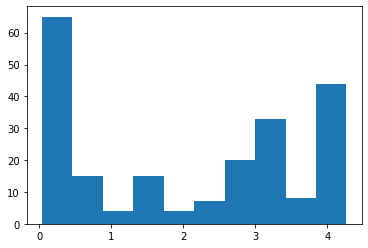

In [15]:
plt.hist(df['square_co2'])

### Reciprocal Transformation

(array([166.,   3.,   0.,  19.,   8.,   5.,   4.,   3.,   4.,   3.]),
 array([5.49450549e-02, 5.71923077e+01, 1.14329670e+02, 1.71467033e+02,
        2.28604396e+02, 2.85741758e+02, 3.42879121e+02, 4.00016484e+02,
        4.57153846e+02, 5.14291209e+02, 5.71428571e+02]),
 <BarContainer object of 10 artists>)

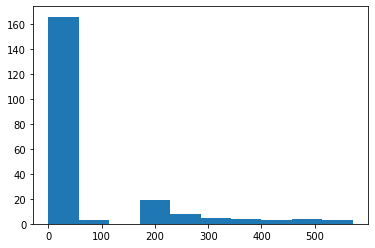

In [16]:
df['rec_co2']=1/df['CO2']
plt.hist(df['rec_co2'])

### Exponential Transformation

In [17]:
df['exp_co2']=np.exp(df['CO2'])
df

,CO2,co2_boxcox,log_co2,square_co2,rec_co2,exp_co2
Year,,,,,,
1800.0,0.00568,-3.094412,-5.170804,0.075366,176.056338,1.005696e+00
1801.0,0.00561,-3.098401,-5.183205,0.074900,178.253119,1.005626e+00
1802.0,0.00555,-3.101852,-5.193957,0.074498,180.180180,1.005565e+00
1803.0,0.00548,-3.105915,-5.206650,0.074027,182.481752,1.005495e+00
1804.0,0.00542,-3.109430,-5.217659,0.073621,184.501845,1.005435e+00
...,...,...,...,...,...,...
2010.0,15.60000,3.767993,2.747271,3.949684,0.064103,5.956538e+06
2011.0,15.60000,3.767993,2.747271,3.949684,0.064103,5.956538e+06
2012.0,14.80000,3.672451,2.694627,3.847077,0.067568,2.676445e+06


(array([181.,   8.,  10.,   8.,   6.,   0.,   0.,   0.,   0.,   2.]),
 array([1.00175153e+00, 8.01972764e+06, 1.60394543e+07, 2.40591809e+07,
        3.20789076e+07, 4.00986342e+07, 4.81183608e+07, 5.61380875e+07,
        6.41578141e+07, 7.21775408e+07, 8.01972674e+07]),
 <BarContainer object of 10 artists>)

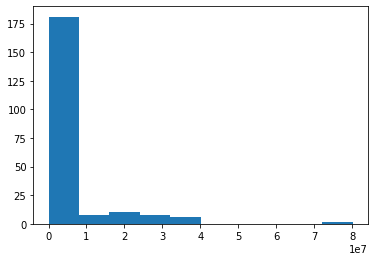

In [18]:
plt.hist(df['exp_co2'])

array([[<AxesSubplot:title={'center':'CO2'}>,
        <AxesSubplot:title={'center':'co2_boxcox'}>],
       [<AxesSubplot:title={'center':'log_co2'}>,
        <AxesSubplot:title={'center':'square_co2'}>],
       [<AxesSubplot:title={'center':'rec_co2'}>,
        <AxesSubplot:title={'center':'exp_co2'}>]], dtype=object)

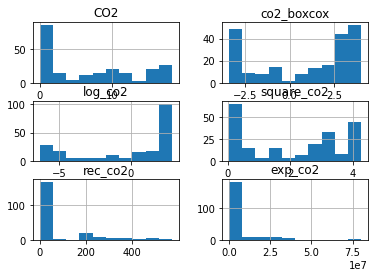

In [19]:
df.hist()

#### Since we did not get any conclusive evidence of being normal distribution. We have decided to move on without transforming it to normal distribution.

In [20]:
df=df.drop(['co2_boxcox','log_co2','square_co2','rec_co2','exp_co2'],axis=1)
df


,CO2
Year,
1800.0,0.00568
1801.0,0.00561
1802.0,0.00555
1803.0,0.00548
1804.0,0.00542
...,...
2010.0,15.60000
2011.0,15.60000
2012.0,14.80000


<AxesSubplot:xlabel='Year'>

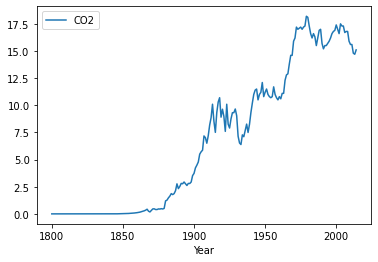

In [21]:
df.plot()

# Data Preprocessing


In [22]:
X=df.values
split=round(len(X)/2)
X1,X2=X[0:split],X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.888644, mean2=12.650000
variance1=2.399437, variance2=13.176064


In [23]:
def TestStationaryPlot(df):
    rol_mean = df.rolling(window = 20, center = False).mean()
    rol_std = df.rolling(window = 20, center = False).std()
    
    plt.plot(df, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('Total Emissions', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

###  null Hypothesis : Data is stationary
### alternate hypothesis : Data is not stationary

In [24]:
def TestStationaryAdfuller(df, cutoff = 0.01):
    df_test = adfuller(df, autolag = 'AIC')
    df_test_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in df_test[4].items():
        df_test_output['Critical Value (%s)'%key] = value
    print(df_test_output)
    
    if df_test[1] <= cutoff:
        print("Failed to reject null hypothesis. Data is stationary")
    else:
        print("Failed to accept null hypothesis. Data is non-stationary ")

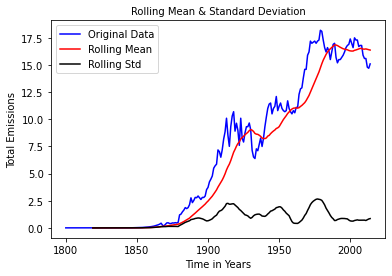

In [25]:
TestStationaryPlot(df)

In [26]:
TestStationaryAdfuller(df)

Test Statistic                  -0.378463
p-value                          0.913633
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


### Transforming data to Stationary by using moving average, differencing and decompostion

### Moving Average

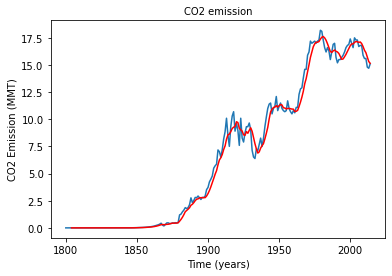

In [27]:
moving_avg = df.rolling(5).mean()
plt.plot(df)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('CO2 Emission (MMT)', fontsize = 10)
plt.title('CO2 emission', fontsize = 10)
plt.show()

In [28]:
moving_avg_diff = df - moving_avg
moving_avg_diff.head(20)

,CO2
Year,
1800.0,NaN
1801.0,NaN
1802.0,NaN
1803.0,NaN
1804.0,-0.000128
1805.0,-0.000124
1806.0,-0.000130
1807.0,-0.000126
1808.0,-0.000124


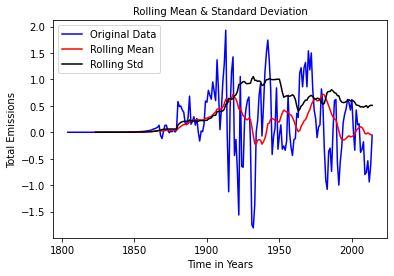

In [29]:
moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(moving_avg_diff)

In [30]:
TestStationaryAdfuller(moving_avg_diff)

Test Statistic                  -3.944115
p-value                          0.001733
#Lags Used                       4.000000
Number of Observations Used    206.000000
Critical Value (1%)             -3.462499
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
dtype: float64
Failed to reject null hypothesis. Data is stationary


### First order differencing

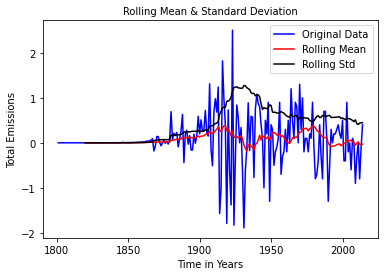

In [31]:
df_first_difference = df - df.shift(1)  
TestStationaryPlot(df_first_difference.dropna(inplace=False))

In [32]:
TestStationaryAdfuller(df_first_difference.dropna(inplace=False))

Test Statistic                  -3.780005
p-value                          0.003119
#Lags Used                      15.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Failed to reject null hypothesis. Data is stationary


### Seasonal First order differencing

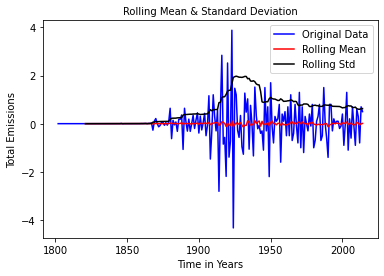

In [33]:
df_seasonal_first_difference = df_first_difference - df_first_difference.shift(1)  
TestStationaryPlot(df_seasonal_first_difference.dropna(inplace=False))

In [34]:
TestStationaryAdfuller(df_seasonal_first_difference.dropna(inplace=False))

Test Statistic                  -5.536081
p-value                          0.000002
#Lags Used                      14.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Failed to reject null hypothesis. Data is stationary


#### We are considering this seasonal first difference for further analysis because it looks more stationary

### Eliminating trend and seasonality: Decomposing

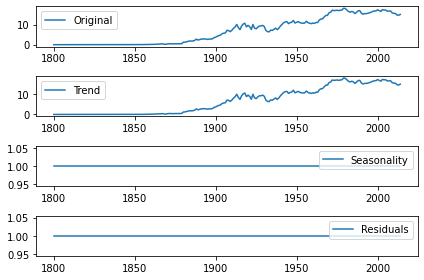

In [35]:
decomposition = seasonal_decompose(df,model="multiplicative",filt=None,period=1,two_sided=True,extrapolate_trend=0)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### Here we can see that the trend, no seasonaltiy in data and we can model the trend. Here original data and trend both are equal.

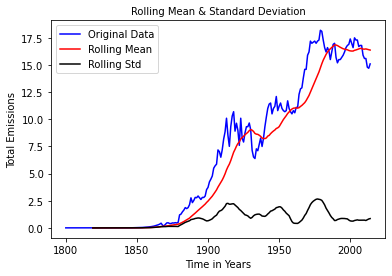

Test Statistic                  -0.378463
p-value                          0.913633
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


In [36]:
df_decompose = trend
df_decompose.dropna(inplace=True)
TestStationaryPlot(df_decompose)
TestStationaryAdfuller(df_decompose)

#ACF & PACF plot for seasonal first order difference

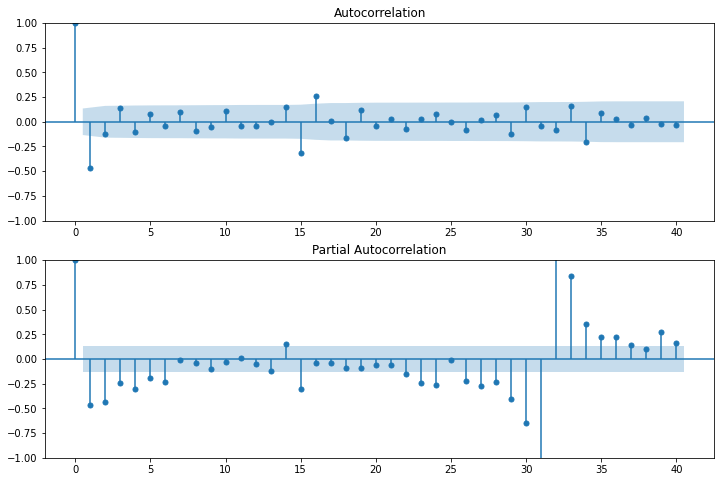

In [37]:
#ACF and PACF plots:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_seasonal_first_difference.dropna(inplace=False), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_seasonal_first_difference.dropna(inplace=False), lags=40, ax=ax2)


##### We will find optimal parameters (p,d,q) using grid search later

# Data Partitioning

In [38]:
#use seasonal first order difference
df_seasonal_first_difference.head()

,CO2
Year,
1800.0,NaN
1801.0,NaN
1802.0,0.00001
1803.0,-0.00001
1804.0,0.00001


In [39]:
X=df_seasonal_first_difference.dropna(inplace=False)

In [40]:
X.head()

,CO2
Year,
1802.0,1.000000e-05
1803.0,-1.000000e-05
1804.0,1.000000e-05
1805.0,-8.673617e-19
1806.0,-1.000000e-05


In [41]:
X.shape

(213, 1)

In [42]:
train=X.iloc[:-20]  ##will create a new DataFrame train that includes all rows of X except for the last 20 rows.

test=X.iloc[-20:]  ##will create a new DataFrame test that includes only the last 20 rows of X.

In [43]:
train.shape

(193, 1)

In [44]:
test.shape

(20, 1)

In [45]:
train.head()

,CO2
Year,
1802.0,1.000000e-05
1803.0,-1.000000e-05
1804.0,1.000000e-05
1805.0,-8.673617e-19
1806.0,-1.000000e-05


In [46]:
test.head()

,CO2
Year,
1995.0,1.776357e-15
1996.0,1.000000e-01
1997.0,1.000000e-01
1998.0,-2.000000e-01
1999.0,-1.000000e-01


# Hyper-parameter tunning

In [47]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [48]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [49]:
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 5]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.613
ARIMA(0, 0, 1) RMSE=0.467
ARIMA(0, 0, 2) RMSE=0.471
ARIMA(0, 1, 0) RMSE=1.037
ARIMA(0, 1, 1) RMSE=0.613
ARIMA(0, 1, 2) RMSE=0.450
ARIMA(0, 2, 0) RMSE=1.853
ARIMA(0, 2, 1) RMSE=1.039
ARIMA(0, 2, 2) RMSE=0.679
ARIMA(1, 0, 0) RMSE=0.546
ARIMA(1, 0, 1) RMSE=0.470
ARIMA(1, 0, 2) RMSE=0.464
ARIMA(1, 1, 0) RMSE=0.838
ARIMA(1, 1, 1) RMSE=0.546
ARIMA(1, 1, 2) RMSE=0.451
ARIMA(1, 2, 0) RMSE=1.374
ARIMA(1, 2, 1) RMSE=0.840
ARIMA(1, 2, 2) RMSE=0.613
ARIMA(2, 0, 0) RMSE=0.443
ARIMA(2, 0, 1) RMSE=0.476
ARIMA(2, 0, 2) RMSE=0.463
ARIMA(2, 1, 0) RMSE=0.634
ARIMA(2, 1, 1) RMSE=0.443
ARIMA(2, 1, 2) RMSE=0.455
ARIMA(2, 2, 0) RMSE=0.999
ARIMA(2, 2, 1) RMSE=0.636
ARIMA(2, 2, 2) RMSE=0.446
ARIMA(3, 0, 0) RMSE=0.433
ARIMA(3, 0, 1) RMSE=0.465
ARIMA(3, 0, 2) RMSE=0.467
ARIMA(3, 1, 0) RMSE=0.573
ARIMA(3, 1, 1) RMSE=0.434
ARIMA(3, 1, 2) RMSE=0.444
ARIMA(3, 2, 0) RMSE=0.863
ARIMA(3, 2, 1) RMSE=0.575
ARIMA(3, 2, 2) RMSE=0.438
ARIMA(4, 0, 0) RMSE=0.457
ARIMA(4, 0, 1) RMSE=0.466
ARIMA(4, 0, 

# ARIMA Model

In [50]:
#3,0,0
model_arima = ARIMA(train['CO2'],order = (3,0,0))
model_arima = model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  193
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -183.744
Date:                Tue, 07 Mar 2023   AIC                            377.488
Time:                        16:11:38   BIC                            393.801
Sample:                             0   HQIC                           384.094
                                - 193                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.019      0.027      0.978      -0.036       0.037
ar.L1         -0.7651      0.047    -16.143      0.000      -0.858      -0.672
ar.L2         -0.5819      0.064     -9.086      0.000      -0.707      -0.456
ar.L3         -0.2375      0.049     -4.837      0.000      -0.334      -0.141
sigma2         0.3914      0.021     18.303      0.000       0.349       0.433
===================================================================================
Ljung-Box (L1) (Q):                   1.21   Jarque-Bera (JB):               284.39
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):           34878.14   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
### make prediction on test set
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

193   -0.167161
194    0.084099
195   -0.013261
196    0.002240
197   -0.012652
198    0.012848
199   -0.001678
200   -0.001865
201    0.000673
202    0.002290
203   -0.000379
204    0.000119
205    0.000907
206    0.000648
207    0.000269
208    0.000523
209    0.000611
210    0.000486
211    0.000470
212    0.000534
Name: predicted_mean, dtype: float64


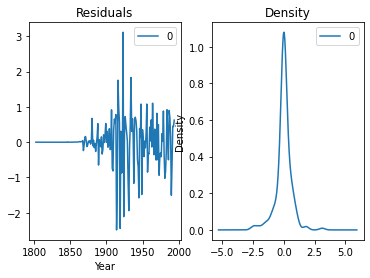

In [52]:
# Plot residual errors
residuals = pd.DataFrame(model_arima.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [53]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

In [54]:
stationary_arima_acc = forecast_accuracy(pred_arima.values, test.values)
stationary_arima_acc

{'mape': inf,
 'me': -0.014513993335686936,
 'mae': 0.48264158866257667,
 'mpe': nan,
 'rmse': 0.613080009448465}

# Auto Regressor (AR) model

In [55]:
model_ar = AutoReg(train,lags = 6).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                  193
Model:                     AutoReg(6)   Log Likelihood                -160.352
Method:               Conditional MLE   S.D. of innovations              0.570
Date:                Tue, 07 Mar 2023   AIC                            336.704
Time:                        16:11:38   BIC                            362.553
Sample:                             6   HQIC                           347.178
                                  193                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.042     -0.081      0.935      -0.085       0.078
CO2.L1        -0.9695      0.071    -13.652      0.000      -1.109      -0.830
CO2.L2        -1.0067      0.095    -10.572      0.0

In [56]:
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

193   -0.355927
194   -0.208764
195    0.053936
196    0.239338
197    0.124217
198   -0.146736
199   -0.040342
200   -0.065187
201    0.009840
202    0.077525
203    0.029742
204   -0.016715
205   -0.048704
206   -0.008430
207    0.008656
208    0.016361
209    0.014504
210   -0.008896
211   -0.013300
212   -0.007153
dtype: float64


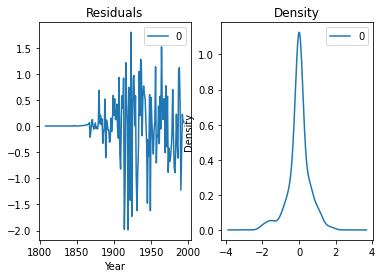

In [57]:
# Plot residual errors
residuals = pd.DataFrame(model_ar.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [58]:
stationary_ar_acc = forecast_accuracy(pred_ar.values, test.values)
stationary_ar_acc

{'mape': inf,
 'me': -0.027301735949541214,
 'mae': 0.4959715255851231,
 'mpe': nan,
 'rmse': 0.6233294379710825}

# Auto-ARIMA Model

In [59]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.0 MB/s eta 0:00:00


In [60]:
import pmdarima as pm

In [61]:
model = pm.auto_arima(train['CO2'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=466.471, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=421.365, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=384.807, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=375.489, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=333.120, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.74 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 4.072 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Obser

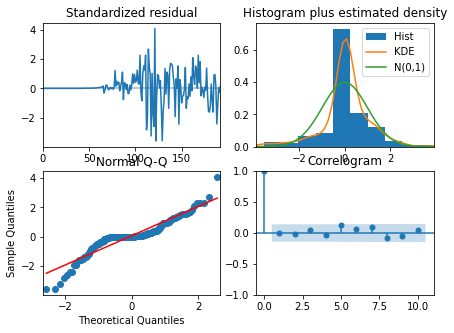

In [62]:
model.plot_diagnostics(figsize=(7,5))
plt.show()


In [63]:
pred_aa = model.predict(start=start,end=end)
print(pred_aa)

193   -1.036471e-01
194   -1.780155e-02
195    1.261574e-02
196    1.423748e-03
197   -1.500342e-03
198   -9.057615e-05
199    1.746967e-04
200    2.005344e-06
201   -1.993642e-05
202    7.173762e-07
dtype: float64


In [64]:
stationary_aa_acc = forecast_accuracy(pred_aa.values, test.values)
stationary_aa_acc

{'mape': inf,
 'me': -0.020884256825681246,
 'mae': 0.482534131099097,
 'mpe': nan,
 'rmse': 0.6126499764988558}

In [65]:
data = {"MODEL":pd.Series(["ARIMA","Auto Regressor","Auto ARIMA"]),"RMSE_Values":pd.Series([stationary_arima_acc["rmse"],stationary_ar_acc["rmse"],
stationary_aa_acc["rmse"]]),"MAPE_values":pd.Series([stationary_arima_acc["mape"],stationary_ar_acc["mape"],stationary_aa_acc["mape"]]),
"ME_values":pd.Series([stationary_arima_acc["me"],stationary_ar_acc["me"],stationary_aa_acc["me"]]),
"MAE_values":pd.Series([stationary_arima_acc["mae"],stationary_ar_acc["mae"],stationary_aa_acc["mae"]]),
        "MPE_values":pd.Series([stationary_arima_acc["mpe"],stationary_ar_acc["mpe"],stationary_aa_acc["mpe"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values,MAPE_values,ME_values,MAE_values,MPE_values
2,Auto ARIMA,0.612650,inf,-0.020884,0.482534,NaN
0,ARIMA,0.613080,inf,-0.014514,0.482642,NaN
1,Auto Regressor,0.623329,inf,-0.027302,0.495972,NaN


#MODEL BUILDING ON NON-STATIONARY DATA / ORIGINAL DATA

In [66]:
df.head()

,CO2
Year,
1800.0,0.00568
1801.0,0.00561
1802.0,0.00555
1803.0,0.00548
1804.0,0.00542


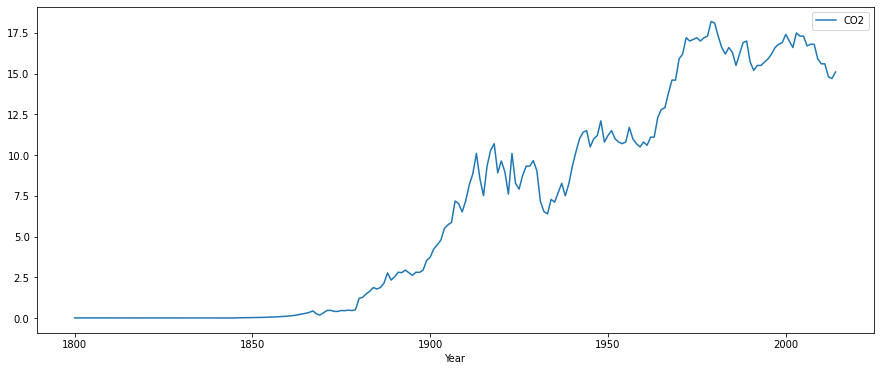

In [67]:
df.plot(figsize=(15, 6))
plt.show()

In [68]:
df.shape

(215, 1)

In [69]:
train = df.iloc[:195]

test = df.iloc[195:]

print(train.shape,test.shape)

(195, 1) (20, 1)


In [70]:
train.head()

,CO2
Year,
1800.0,0.00568
1801.0,0.00561
1802.0,0.00555
1803.0,0.00548
1804.0,0.00542


In [71]:
test.head()

,CO2
Year,
1995.0,15.9
1996.0,16.2
1997.0,16.6
1998.0,16.8
1999.0,16.9


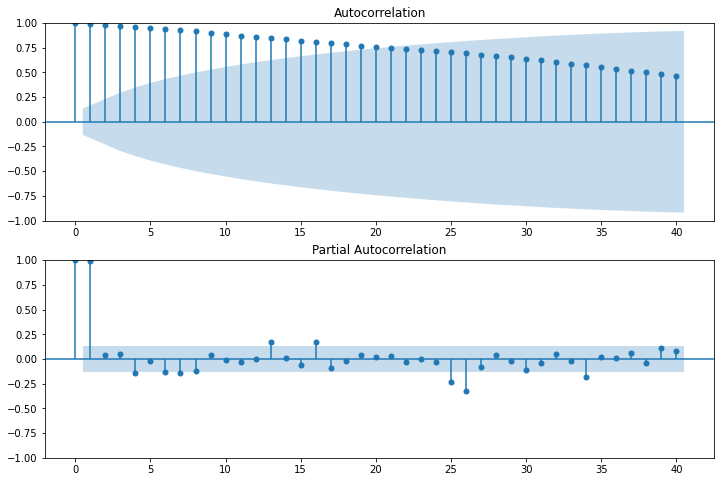

In [72]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=40, ax=ax2)

In [73]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [74]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [75]:
# evaluate parameters
p_values = [0,1,2,3,4,5]
#p_values = [0,1,2,3]
d_values = range(0, 5)
q_values = range(0, 5)

warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=10.175
ARIMA(0, 0, 1) RMSE=5.218
ARIMA(0, 0, 2) RMSE=3.120
ARIMA(0, 0, 3) RMSE=1.965
ARIMA(0, 0, 4) RMSE=1.885
ARIMA(0, 1, 0) RMSE=0.438
ARIMA(0, 1, 1) RMSE=0.439
ARIMA(0, 1, 2) RMSE=0.439
ARIMA(0, 1, 3) RMSE=0.424
ARIMA(0, 1, 4) RMSE=0.424
ARIMA(0, 2, 0) RMSE=0.612
ARIMA(0, 2, 1) RMSE=0.451
ARIMA(0, 2, 2) RMSE=0.454
ARIMA(0, 2, 3) RMSE=0.458
ARIMA(0, 2, 4) RMSE=0.443
ARIMA(0, 3, 0) RMSE=1.037
ARIMA(0, 3, 1) RMSE=0.613
ARIMA(0, 3, 2) RMSE=0.450
ARIMA(0, 3, 3) RMSE=0.453
ARIMA(0, 3, 4) RMSE=0.460
ARIMA(0, 4, 0) RMSE=1.853
ARIMA(0, 4, 1) RMSE=1.039
ARIMA(0, 4, 2) RMSE=0.679
ARIMA(0, 4, 3) RMSE=0.437
ARIMA(0, 4, 4) RMSE=9.732
ARIMA(1, 0, 0) RMSE=0.437
ARIMA(1, 0, 1) RMSE=0.438
ARIMA(1, 0, 2) RMSE=0.438
ARIMA(1, 0, 3) RMSE=0.423
ARIMA(1, 0, 4) RMSE=0.423
ARIMA(1, 1, 0) RMSE=0.439
ARIMA(1, 1, 1) RMSE=0.433
ARIMA(1, 1, 2) RMSE=0.431
ARIMA(1, 1, 3) RMSE=0.437
ARIMA(1, 1, 4) RMSE=0.440
ARIMA(1, 2, 0) RMSE=0.544
ARIMA(1, 2, 1) RMSE=0.453
ARIMA(1, 2, 2) RMSE=0.446
ARIMA(1, 2,

# ARIMA

In [76]:
model_arima = ARIMA(train['CO2'],order = (3,1,4))
model_arima = model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  195
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -156.500
Date:                Tue, 07 Mar 2023   AIC                            329.001
Time:                        16:40:10   BIC                            355.144
Sample:                             0   HQIC                           339.587
                                - 195                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4656      0.216      6.785      0.000       1.042       1.889
ar.L2         -0.0859      0.412     -0.208      0.835      -0.893       0.722
ar.L3         -0.4541      0.214     -2.118      0.034      -0.874      -0.034
ma.L1         -1.5393      0.226     -6.823      0.000      -1.981      -1.097
ma.L2          0.0455      0.410      0.111      0.912      -0.758       0.849
ma.L3          0.7809      0.209      3.735      0.000       0.371       1.191
ma.L4         -0.2128      0.057     -3.711      0.000      -0.325      -0.100
sigma2         0.2907      0.024     11.993      0.000       0.243       0.338
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                74.48
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):            3462.64   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

195    15.889929
196    16.094217
197    16.345280
198    16.597525
199    16.852875
200    17.091435
201    17.304583
202    17.480519
203    17.611724
204    17.692111
205    17.718760
206    17.691327
207    17.612327
208    17.486801
209    17.322074
210    17.127311
211    16.913020
212    16.690493
213    16.471213
214    16.266266
Name: predicted_mean, dtype: float64


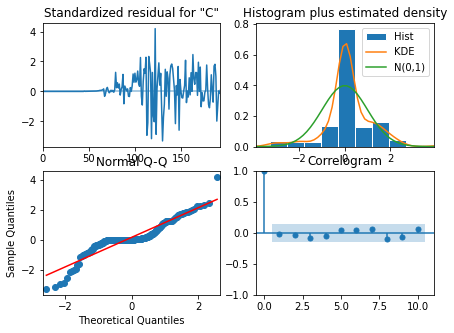

In [78]:
model_arima.plot_diagnostics(figsize=(7,5))
plt.show()

In [79]:
ns_arima_acc = forecast_accuracy(pred_arima.values,test.CO2)
ns_arima_acc

{'mape': 0.04624330198984401,
 'me': 0.6379895242148697,
 'mae': 0.7308634501814096,
 'mpe': 0.04073510468725071,
 'rmse': 0.9404496751966939}

## Single Exponential Smoothening

In [80]:
ses_model = SimpleExpSmoothing(train.CO2).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = len(train),end = len(train)+len(test)-1)

In [81]:
def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'Simple Exponential Smoothing Model RMSE':rmse})

In [82]:
SES_acc = forecast_accuracy(pred_ses.values, test.values)
SES_acc

{'Simple Exponential Smoothing Model RMSE': 0.9682045310926879}

## Double Exponential Smoothing or Holt's method


In [83]:
hw_model = Holt(train.CO2).fit(smoothing_level=0.8,smoothing_slope=0.2)
pred_hw = hw_model.predict(start = len(train),end = len(train)+len(test)-1)

In [84]:
def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'Double Exponential Smoothing Model RMSE':rmse})

In [85]:
DES_acc = forecast_accuracy(pred_hw.values, test.values)
DES_acc

{'Double Exponential Smoothing Model RMSE': 1.6957306698146153}

## Winter's Method

In [86]:
hwe_model_add = ExponentialSmoothing(train["CO2"],seasonal="add",trend="add",seasonal_periods=2).fit() 
pred_hwe_add_add = hwe_model_add.predict(start = start,end = end)

In [87]:
def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'Holts Winter Smoothing Model RMSE':rmse})

In [88]:
Holt_acc = forecast_accuracy(pred_hwe_add_add.values, test.values)
Holt_acc

{'Holts Winter Smoothing Model RMSE': 0.9719107990665937}

## Holts winter ES with multiplicative seasonality and additive trend


In [89]:
hwe_model_mul_add = ExponentialSmoothing(train["CO2"],seasonal="mul",trend="add",seasonal_periods=2).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = start,end = end)

In [90]:
def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'Holts Winter SE with multiplicative seasonality and additive trend RMSE':rmse})

In [91]:
Holt_acc1 = forecast_accuracy(pred_hwe_mul_add.values, test.values)
Holt_acc1

{'Holts Winter SE with multiplicative seasonality and additive trend RMSE': 0.9684473918296527}

## Holts winter ES with multiplicative seasonality and multiplicative trend

In [92]:
hwe_model_mul_mul = ExponentialSmoothing(train["CO2"],seasonal="mul",trend="mul",seasonal_periods=2).fit()
pred_hwe_mul_mul = hwe_model_mul_mul.predict(start = start,end = end)

In [93]:
def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'Holts Winter ES with multiplicative seasonality and  multiplicative trend RMSE':rmse})

In [94]:
Holt_acc2 = forecast_accuracy(pred_hwe_mul_mul.values, test.values)
Holt_acc2

{'Holts Winter ES with multiplicative seasonality and  multiplicative trend RMSE': 1.2077266834977682}

In [95]:
ns_arima_acc['rmse']

0.9404496751966939

In [96]:
SES_acc


{'Simple Exponential Smoothing Model RMSE': 0.9682045310926879}

In [97]:
df1=pd.read_excel('CO2 dataset.xlsx',header=0, index_col=0, parse_dates=True)
df1

,CO2
Year,
1800.0,0.00568
1801.0,0.00561
1802.0,0.00555
1803.0,0.00548
1804.0,0.00542
...,...
2010.0,15.60000
2011.0,15.60000
2012.0,14.80000


In [98]:
df1["t"] = np.arange(0,215)
df1["t_squared"] = df1["t"] * df1["t"]
df1["Log_Temp"] = np.log(df1["CO2"])   ### stabilize the variance and make the data more amenable to statistical modeling.
df1

,CO2,t,t_squared,Log_Temp
Year,,,,
1800.0,0.00568,0,0,-5.170804
1801.0,0.00561,1,1,-5.183205
1802.0,0.00555,2,4,-5.193957
1803.0,0.00548,3,9,-5.206650
1804.0,0.00542,4,16,-5.217659
...,...,...,...,...
2010.0,15.60000,210,44100,2.747271
2011.0,15.60000,211,44521,2.747271
2012.0,14.80000,212,44944,2.694627


In [99]:
train = df1.iloc[:195]
test = df1.iloc[195:]
print(train.shape,test.shape)

(195, 4) (20, 4)


### Linear Model

In [100]:
import statsmodels.formula.api as smf
import numpy as np

linear_model = smf.ols('CO2~t',data=train).fit() #Training
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t']))) #Testing
rmse_linear = np.sqrt(np.mean((np.array(test['CO2'])-np.array(pred_linear))**2)) #Evaluation metric - RMSE
rmse_linear

1.2772233269805124

### Exponential Model

In [101]:
Exp = smf.ols('Log_Temp~t',data=train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test['CO2'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

236.4719355746894

### Quadratic Model

In [102]:
#Quadratic
Quad = smf.ols('CO2~t+t_squared',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test['CO2'])-np.array(pred_Quad))**2))
rmse_Quad

5.096472215502549

In [103]:
print(ns_arima_acc['rmse'])
print(SES_acc)
print(DES_acc)
print(Holt_acc)
print(Holt_acc1)
print(Holt_acc2)
print("RMSE of Linear Model is",rmse_linear)
print("RMSE of Exponential Model is",rmse_Exp)
print("RMSE of Quadratic Model is",rmse_Quad)

0.9404496751966939
{'Simple Exponential Smoothing Model RMSE': 0.9682045310926879}
{'Double Exponential Smoothing Model RMSE': 1.6957306698146153}
{'Holts Winter Smoothing Model RMSE': 0.9719107990665937}
{'Holts Winter SE with multiplicative seasonality and additive trend RMSE': 0.9684473918296527}
{'Holts Winter ES with multiplicative seasonality and  multiplicative trend RMSE': 1.2077266834977682}
RMSE of Linear Model is 1.2772233269805124
RMSE of Exponential Model is 236.4719355746894
RMSE of Quadratic Model is 5.096472215502549


## Final Model

In [151]:
final_arima_test = ARIMA(df1['CO2'],order = (3,1,4))
final_arima_test = final_arima_test.fit()
final_arima_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  215
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -166.984
Date:                Tue, 07 Mar 2023   AIC                            349.968
Time:                        17:36:26   BIC                            376.895
Sample:                             0   HQIC                           360.849
                                - 215                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4805      0.189      7.829      0.000       1.110       1.851
ar.L2         -0.1107      0.363     -0.305      0.760      -0.822       0.600
ar.L3         -0.4446      0.188     -2.360      0.018      -0.814      -0.075
ma.L1         -1.5635      0.196     -7.973      0.000      -1.948      -1.179
ma.L2          0.0744      0.361      0.206      0.837      -0.633       0.781
ma.L3          0.7941      0.187      4.255      0.000       0.428       1.160
ma.L4         -0.2327      0.052     -4.499      0.000      -0.334      -0.131
sigma2         0.2757      0.021     13.162      0.000       0.235       0.317
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                78.18
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):             231.62   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [152]:
final_arima_test.fittedvalues.tail()

Year
2010.0    15.746929
2011.0    15.433681
2012.0    15.301867
2013.0    14.560096
2014.0    14.550811
dtype: float64

In [106]:
data1 = pd.read_excel('CO2 dataset.xlsx', header=0, index_col=0, parse_dates=True)

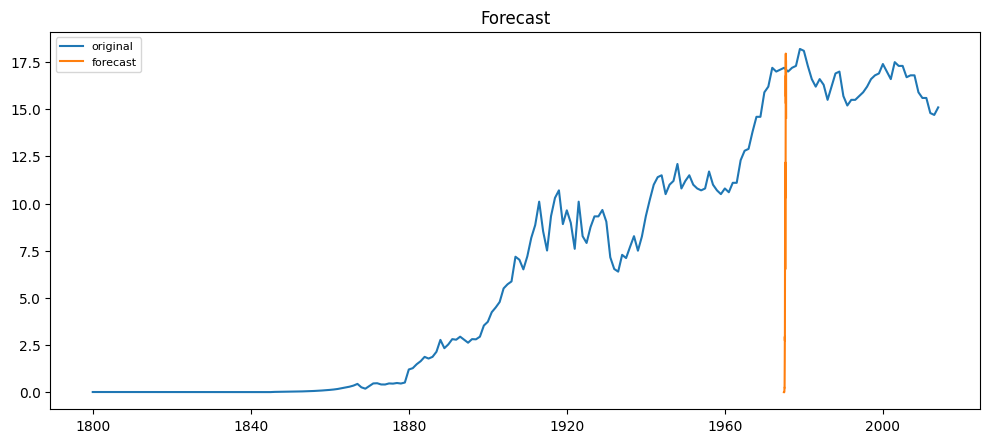

In [153]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data1, label='original')
#plt.plot(test, label='actual')
plt.plot(final_arima_test.fittedvalues, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Forecasting for 5 Years

In [108]:
data1.head()

,CO2
Year,
1800.0,0.00568
1801.0,0.00561
1802.0,0.00555
1803.0,0.00548
1804.0,0.00542


In [127]:
data1.isna().sum()

CO2    0
dtype: int64

In [109]:
data1.reset_index(inplace=True)

In [110]:
data1.head()

,Year,CO2
0,1800.0,0.00568
1,1801.0,0.00561
2,1802.0,0.00555
3,1803.0,0.00548
4,1804.0,0.00542


In [111]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    float64
 1   CO2     215 non-null    float64
dtypes: float64(2)
memory usage: 3.5 KB


In [112]:
data1['Year'] = pd.to_datetime(data1['Year'], format='%Y', errors='coerce')

In [113]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Year    215 non-null    datetime64[ns]
 1   CO2     215 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.5 KB


In [114]:
from pandas.tseries.offsets import DateOffset

In [115]:
data1.set_index('Year', inplace=True)

In [116]:
data1.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [117]:
future_dates=[data1.index[-1]+ DateOffset(years=x)for x in range(0,6)]

In [118]:
future_df=pd.DataFrame(index=future_dates[1:],columns=data1.columns)

In [119]:
future_df

,CO2
2015-01-01,NaN
2016-01-01,NaN
2017-01-01,NaN
2018-01-01,NaN
2019-01-01,NaN


In [121]:
future_df.tail()

,CO2
2015-01-01,NaN
2016-01-01,NaN
2017-01-01,NaN
2018-01-01,NaN
2019-01-01,NaN


In [122]:
len(future_df)

5

In [140]:
final_arima = ARIMA(data1['CO2'],order = (3,1,4))
final_arima = final_arima.fit()
final_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  215
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -166.984
Date:                Tue, 07 Mar 2023   AIC                            349.968
Time:                        17:26:28   BIC                            376.895
Sample:                    01-01-1800   HQIC                           360.849
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4805      0.189      7.829      0.000       1.110       1.851
ar.L2         -0.1107      0.363     -0.305      0.760      -0.822       0.600
ar.L3         -0.4446      0.188     -2.360      0.018      -0.814      -0.075
ma.L1         -1.5635      0.196     -7.973      0.000      -1.948      -1.179
ma.L2          0.0744      0.361      0.206      0.837      -0.633       0.781
ma.L3          0.7941      0.187      4.255      0.000       0.428       1.160
ma.L4         -0.2327      0.052     -4.499      0.000      -0.334      -0.131
sigma2         0.2757      0.021     13.162      0.000       0.235       0.317
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                78.18
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):             231.62   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [141]:
future_df['CO2'] = final_arima.predict(start = 215, end = 220, dynamic= False)  

In [142]:
future_df

,CO2
2015-01-01,14.773561
2016-01-01,14.559110
2017-01-01,14.503463
2018-01-01,14.462163
2019-01-01,14.502526


In [143]:
# Exporting to csv file# Exporting to csv file
future_df.to_csv(r'forecast_data_5years1.csv',index=True)

## Forecast for 10 years

In [144]:
future_dates_10=[data1.index[-1]+ DateOffset(years=x)for x in range(0,11)]
future_df_10=pd.DataFrame(index=future_dates_10[1:],columns=data1.columns)
future_df_10.tail()
len(future_df_10)

10

In [145]:
future_df_10

,CO2
2015-01-01,NaN
2016-01-01,NaN
2017-01-01,NaN
2018-01-01,NaN
2019-01-01,NaN
2020-01-01,NaN
2021-01-01,NaN
2022-01-01,NaN
2023-01-01,NaN
2024-01-01,NaN


In [146]:
future_df_10['CO2'] = final_arima.predict(start = 215, end = 225, dynamic= True) 

In [148]:
future_df_10

,CO2
2015-01-01,14.773561
2016-01-01,14.559110
2017-01-01,14.503463
2018-01-01,14.462163
2019-01-01,14.502526
2020-01-01,14.591596
2021-01-01,14.737352
2022-01-01,14.925328
2023-01-01,15.147876
2024-01-01,15.391729


In [150]:
# Exporting to csv file
future_df_10.to_csv(r'forecast_data_10years.csv',index=True)

In [154]:
# Saving the pickle file
import pickle
pickle.dump(final_arima, open('Forecast_arima.pkl','wb'))